In [1]:
from __future__ import print_function
import os
import sys
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, SimpleRNN, Activation, GRU, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
base_dir = r'C:\Users\I\Desktop\Neural networks\Neural network data\Case3'
glove_dir = os.path.join(base_dir, 'glove.6B')
dataTrain = pd.read_csv(r'C:/Users/I/Desktop/Neural networks/Neural network data/Case3/drugsComTrain_raw.csv')
dataTest = pd.read_csv(r'C:/Users/I/Desktop/Neural networks/Neural network data/Case3/drugsComTest_raw.csv')

In [3]:
# Tokenize the text
samples = dataTrain['review']
samplesTest = dataTest['review']

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(samples)
tokenizer.fit_on_texts(samplesTest)
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(samples)
sequencesTest = tokenizer.texts_to_sequences(samplesTest)

word_index = tokenizer.word_index

print('Found %s unique tokens in train data.' % len(word_index))

#pad sequences
Data = pad_sequences(sequences, maxlen=200)
DataTest = pad_sequences(sequencesTest, maxlen=200)

Found 55245 unique tokens in train data.


In [4]:
# Create six categories for train and testing 
# label = 5, when rating == 10
# label = 4, when rating = 8-9
# label = 3, when rating = 6-7
# label = 2, when rating = 4-5
# label = 1, when rating = 2-3
# label = 0, when rating == 1
Labels = dataTrain['rating'].values
for i in range(len(Labels)):
    x = Labels[i]
    if x == 10:
        Labels[i] = 5
    elif x >= 8:
        Labels[i] = 4
    elif x >= 6:
        Labels[i] = 3
    elif x >= 4:
        Labels[i] = 2
    elif x >= 2:    
        Labels[i] = 1
    else:
        Labels[i] = 0

LabelsTest = dataTest['rating'].values
for i in range(len(LabelsTest)):
    x = LabelsTest[i]
    if x == 10:
        LabelsTest[i] = 5
    elif x >= 8:
        LabelsTest[i] = 4
    elif x >= 6:
        LabelsTest[i] = 3
    elif x >= 4:
        LabelsTest[i] = 2
    elif x >= 2:    
        LabelsTest[i] = 1
    else:
        LabelsTest[i] = 0        

In [5]:
Labels = to_categorical(np.asarray(Labels))
LabelsTest = to_categorical(np.asarray(LabelsTest))
print('Shape of train data tensor:', Data.shape)
print('Shape of train label tensor:', Labels.shape)
print('Shape of test data tensor:', DataTest.shape)
print('Shape of test label tensor:', LabelsTest.shape)

Shape of train data tensor: (161297, 200)
Shape of train label tensor: (161297, 6)
Shape of test data tensor: (53766, 200)
Shape of test label tensor: (53766, 6)


In [6]:
validation_split = 0.3

# split the data into a training set and a validation set
indices = np.arange(Data.shape[0])
np.random.shuffle(indices)
Data = Data[indices]
Labels = Labels[indices]
nb_validation_samples = int(validation_split * Data.shape[0])

x_train = Data[:-nb_validation_samples]
y_train = Labels[:-nb_validation_samples]
x_validation = Data[-nb_validation_samples:]
y_validation = Labels[-nb_validation_samples:]

In [7]:
embeddings_index = {}
with open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [8]:
num_words = min(5000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, 100))
for word, i in word_index.items():
    if i >= 5000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Since glove.6B.100d is used, output is 100.

In [9]:
embedding_layer = Embedding(num_words,
                            100,
                            weights=[embedding_matrix],
                            input_length=200,
                            trainable=False)

In [10]:
sequence_input = Input(shape=(200,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)

prediction = Dense(6, activation='softmax')(x)

model = Model(sequence_input, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 128)            82048 

In [11]:
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_validation, y_validation))

Train on 112908 samples, validate on 48389 samples
Epoch 1/10
112908/112908 [==============================] - 77s 684us/sample - loss: 1.4755 - acc: 0.3936 - val_loss: 1.4467 - val_acc: 0.3847
Epoch 2/10
112908/112908 [==============================] - 75s 661us/sample - loss: 1.3046 - acc: 0.4624 - val_loss: 1.3915 - val_acc: 0.4341 - loss: 1.3151 - acc:  - ETA: 23s - loss: 1.3149 - acc - ETA: 23s - loss: 1 - ETA: 6s - l - ETA: 0s - loss: 1.3051 - acc:
Epoch 3/10
112908/112908 [==============================] - 72s 636us/sample - loss: 1.2154 - acc: 0.4963 - val_loss: 1.2738 - val_acc: 0.4784
Epoch 4/10
112908/112908 [==============================] - 73s 643us/sample - loss: 1.1307 - acc: 0.5298 - val_loss: 1.3174 - val_acc: 0.4542
Epoch 5/10
112908/112908 [==============================] - 72s 637us/sample - loss: 1.0491 - acc: 0.5674 - val_loss: 1.4662 - val_acc: 0.4479A: 19s - loss: 1.0460  - ETA:
Epoch 6/10
112908/112908 [==============================] - 73s 649us/sample - loss

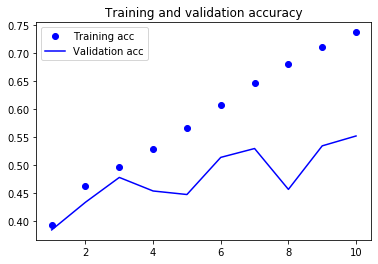

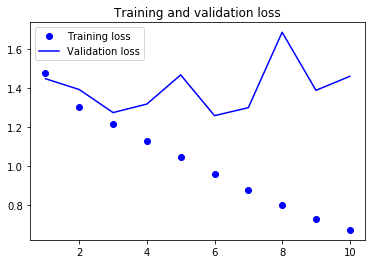

<Figure size 432x288 with 0 Axes>

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.show()

<Figure size 432x288 with 0 Axes>

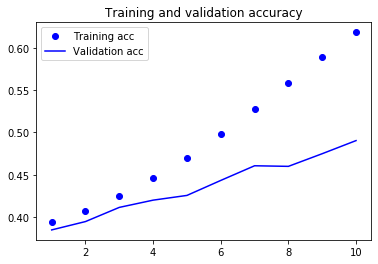

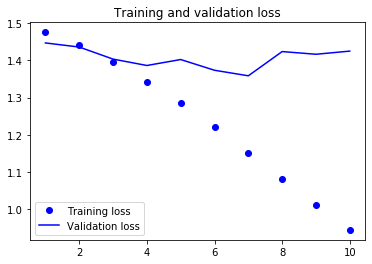

<Figure size 432x288 with 0 Axes>

In [13]:
epochs = range(1, len(acc) + 1)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

In [14]:
# Find the predicted values for the test set
y_pred = np.argmax(model.predict(DataTest), axis = 1)
y_true = np.argmax(LabelsTest, axis = 1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred).T
print(cm)
# Calcualte classification report
cr = classification_report(y_true, y_pred)
print(cr)

[[ 4234   827   398   229   249   253]
 [  817  1555   324   205   168   104]
 [  672   787  1710   541   490   262]
 [  249   323   532  1437   683   270]
 [  820   770  1094  2186  9949  5358]
 [  507   277   311   612  3794 10769]]
              precision    recall  f1-score   support

           0       0.68      0.58      0.63      7299
           1       0.49      0.34      0.40      4539
           2       0.38      0.39      0.39      4369
           3       0.41      0.28      0.33      5210
           4       0.49      0.65      0.56     15333
           5       0.66      0.63      0.65     17016

    accuracy                           0.55     53766
   macro avg       0.52      0.48      0.49     53766
weighted avg       0.56      0.55      0.55     53766



In [15]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.413
Cohen's kappa (quadratic) = 0.710


As can be seen from the graph, model training should be stopped at 6 epochs to avoid overfitting. The results are fairly good with six classes but they are again worse with a pre-trained network.

Lets try training with full training data set to improve results and lessen overfitting.

In [16]:
sequence_input = Input(shape=(200,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)

prediction = Dense(6, activation='softmax')(x)

model = Model(sequence_input, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [18]:
history = model.fit(Data, Labels,
          batch_size=128,
          epochs=6,
          validation_data=None)

Train on 161297 samples
Epoch 1/6
161297/161297 [==============================] - 101s 628us/sample - loss: 1.4353 - acc: 0.4111: 6s -  - ETA: 3s - loss: 1.4394 - acc: 0.409 - ETA: 3s - loss: 1.4393 - acc - ETA: 2s -
Epoch 2/6
161297/161297 [==============================] - 91s 565us/sample - loss: 1.2666 - acc: 0.4769
Epoch 3/6
161297/161297 [==============================] - 99s 614us/sample - loss: 1.1743 - acc: 0.5104A: 7s - loss: 1. - ETA: 5s - loss: 1.1735  - - ETA: 0s - loss: 1.1743 - acc: 0.510
Epoch 4/6
161297/161297 [==============================] - 97s 604us/sample - loss: 1.0921 - acc: 0.5458ETA: 0s - loss: 1.0922 - acc: 0
Epoch 5/6
161297/161297 [==============================] - 100s 619us/sample - loss: 1.0099 - acc: 0.5831 - loss: 1. - ETA - ETA: 22s - lo - ETA: 21s - loss: 1.0058 - acc:  - E - ETA: 19s - loss:  - ETA: 18s - loss: 1.0064 - ETA: 17s - loss: 1.0066 - acc - - ETA: 11s  - ETA: 10s - loss: 1.0086 - ETA: 5s - loss: 1.0095 - acc - ETA: 4s - lo - ETA: 1s - l

In [19]:
# Find the predicted values for the test set
y_pred = np.argmax(model.predict(DataTest), axis = 1)
y_true = np.argmax(LabelsTest, axis = 1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred).T
print(cm)
# Calcualte classification report
cr = classification_report(y_true, y_pred)
print(cr)

[[ 4483  1232   495   229   250   215]
 [  334   586   212    78    56    32]
 [  279   445   442   129    66    41]
 [  633  1042  1512  1629  1083   372]
 [  853   866  1304  2464  9427  5183]
 [  717   368   404   681  4451 11173]]
              precision    recall  f1-score   support

           0       0.65      0.61      0.63      7299
           1       0.45      0.13      0.20      4539
           2       0.32      0.10      0.15      4369
           3       0.26      0.31      0.28      5210
           4       0.47      0.61      0.53     15333
           5       0.63      0.66      0.64     17016

    accuracy                           0.52     53766
   macro avg       0.46      0.40      0.41     53766
weighted avg       0.51      0.52      0.50     53766



In [20]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.360
Cohen's kappa (quadratic) = 0.678


The result is worse than when training for 10 epochs which is a bit weird considering that the result should be better since, we don't overfit the model but then again it could be that, the training data and test data are similar in nature. Resulting overfitting isn't yet that bad between 6 and 10 epochs but within those 4 epochs the trainable parameters will get better and by that the model fares better after 10 epochs. Lets see Case 3 Three rating categories glove.6B.200d V2